# Exercise 3: Wine Regression?!

In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import sklearn

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

# Let's check our software versions
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### SciPy version: ' + sp.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('------------')

# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

### Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
### NumPy version: 1.19.5
### SciPy version: 1.5.0
### Scikit-learn version: 0.23.1
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 17

np.random.seed(seed) # deterministic seed for reproducibility

## Interesting stuff starts now

### Loading data

In [3]:
# Use pandas to load the data from compressed CSV
wine_type = 'red'
#wine_type = 'white'

df = pd.read_csv('../data/{}-wine-quality.csv'.format(wine_type), header=0, na_values='?', sep=' *; *', skipinitialspace=True, engine='python')

In [4]:
# Check that we loaded the data as expected
if wine_type == 'white':
    df_expected_shape = (4898,12)
else:
    df_expected_shape = (1599,12)
    
assert df.shape == df_expected_shape, 'Unexpected shape of df!'

In [5]:
# Quick tip: use info() to get a glance at the size and attributes of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
# Let's look at a few rows of our dataframe
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [7]:
# how many records do we have?
df.shape

(1599, 12)

### Pre-processing data

In [8]:
## header right now: fixed acidity;volatile acidity;citric acid;residual sugar;chlorides;free sulfur dioxide;total sulfur dioxide;density;pH;sulphates;alcohol;quality
col_names = df.columns
col_names = [x for x in col_names]

#### all columns are numerical and the last one 'quality' is what we want to predict
#### Note: quality is a score between 0 (very bad) and 10 (excellent)

In [9]:
# grab all the data as a numpy array
all_xy = np.asarray(df, dtype='float64')
assert all_xy.shape[1] == 12

label_col_idx = all_xy.shape[1]-1
features_col_idx = range(0, label_col_idx)

feature_names = col_names[0:label_col_idx]

#### Let's separate features from labels

In [10]:
# separate features from the label
all_x = all_xy[:,features_col_idx]
all_y = all_xy[:,label_col_idx]
all_y = all_y.astype(int)

### Train, Test, Validation Split

In [11]:
# now split between train, test, and validation
prop_vec = [14, 3, 3]
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x, all_y, prop_vec, shuffle=True, seed=seed)

In [12]:
# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((1120, 11), (1120,), (240, 11), (240,), (239, 11), (239,))

### Stats & Looking at the data

In [13]:
# what does the distribution of labels look like?
label_name = col_names[-1]
utils.print_array_hist(train_y, label=label_name)

--- quality ---
3: 6
4: 31
5: 476
6: 456
7: 136
8: 15


### Clearly, this is not a balanced dataset (we will see later on why this can matter)

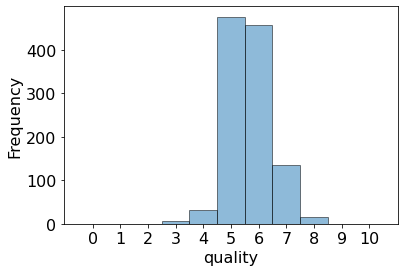

In [14]:
# let's plot a histogram to visualize the distribution of labels
bins = np.arange(-1, 11) + 0.5

plt.hist(train_y, bins, density=False, alpha=0.5, edgecolor='k', label=label_name)

plt.xticks(np.arange(11))
plt.xlabel(label_name)
plt.ylabel('Frequency')
plt.show()

### Question: what do you think is a good baseline for predicting the quality exactly?

In [15]:
# what does the distribution of features look like?
for i in range(train_x.shape[1]):
    utils.print_array_basic_stats(train_x[:, i], label=col_names[i])
    print()

--- fixed acidity ---
min: 4.60
max: 15.50
mean (+- std): 8.32 (+- 1.74)

--- volatile acidity ---
min: 0.12
max: 1.58
mean (+- std): 0.53 (+- 0.18)

--- citric acid ---
min: 0.00
max: 0.79
mean (+- std): 0.27 (+- 0.20)

--- residual sugar ---
min: 1.20
max: 15.50
mean (+- std): 2.52 (+- 1.38)

--- chlorides ---
min: 0.01
max: 0.61
mean (+- std): 0.09 (+- 0.05)

--- free sulfur dioxide ---
min: 1.00
max: 68.00
mean (+- std): 16.03 (+- 10.49)

--- total sulfur dioxide ---
min: 6.00
max: 289.00
mean (+- std): 46.83 (+- 32.69)

--- density ---
min: 0.99
max: 1.00
mean (+- std): 1.00 (+- 0.00)

--- pH ---
min: 2.87
max: 4.01
mean (+- std): 3.31 (+- 0.15)

--- sulphates ---
min: 0.33
max: 1.98
mean (+- std): 0.66 (+- 0.17)

--- alcohol ---
min: 8.50
max: 14.00
mean (+- std): 10.41 (+- 1.06)



### Question: Do the features even help us predict the quality?

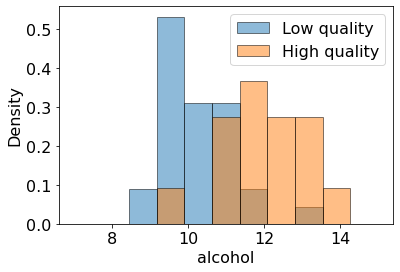

In [16]:
# plot feature distribution based on quality

#feature_idx = 0; bins = np.linspace(3, 12, 12)
#feature_idx = 3; bins = np.linspace(0, 70, 20)
feature_idx = 10; bins = np.linspace(7, 15, 12)

lowq_idx = train_y == 4 # low quality wines
highq_idx = train_y == 8 # high quality wines

plt.hist(train_x[lowq_idx,feature_idx], bins, density=True, alpha=0.5, edgecolor='k', label='Low quality')
plt.hist(train_x[highq_idx,feature_idx], bins, density=True, alpha=0.5, edgecolor='k', label='High quality')

plt.xlabel('{}'.format(col_names[feature_idx]))
plt.ylabel('Density')

plt.legend(loc='upper right')
plt.show()

### Can we look at the statistical information that features contain about the task in a systematic way?

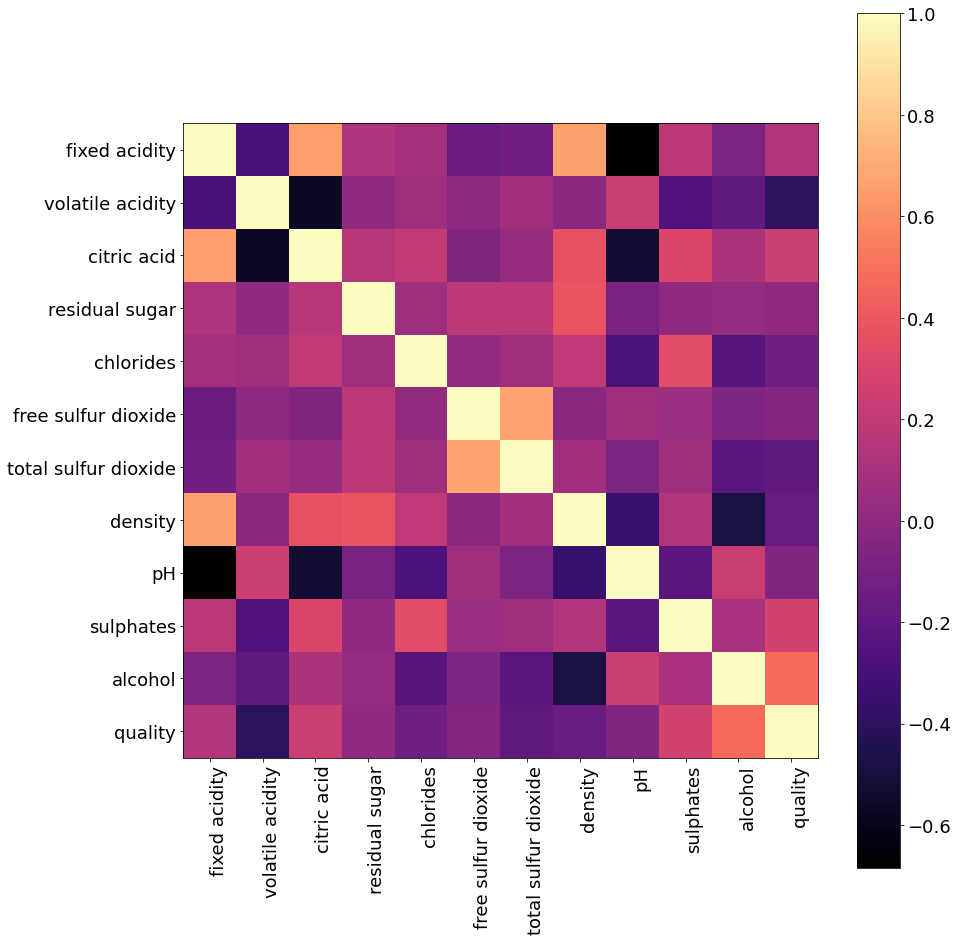

In [17]:
# Hint: this may be in your assignment!

train_xy = np.hstack((train_x, train_y.reshape(-1, 1)))

pairwise_corr = np.corrcoef(train_xy, rowvar=False)

plots.heatmap(pairwise_corr, col_names, col_names, rot=90, fsz=(14, 14))

### [Left as exercise]: use Pandas' scatter_matrix to look at scatter plots for the correlation. *Good exercise

In [18]:
## Ref: https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html

## Rescale features

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True)
scaler.fit(all_x) 

scaled_all_x = scaler.transform(all_x)

## Let's split the *scaled* data!

In [20]:
# now split between train, test, and validation!
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x, all_y, prop_vec, shuffle=True, seed=seed)

In [21]:
# what does the distribution of features look like now that we have done scaling?
for i in range(train_x.shape[1]):
    utils.print_array_basic_stats(train_x[:, i], label=col_names[i])
    print()

--- fixed acidity ---
min: -2.14
max: 4.13
mean (+- std): 0.00 (+- 1.00)

--- volatile acidity ---
min: -2.28
max: 5.88
mean (+- std): 0.00 (+- 1.01)

--- citric acid ---
min: -1.39
max: 2.67
mean (+- std): -0.00 (+- 1.00)

--- residual sugar ---
min: -0.95
max: 9.20
mean (+- std): -0.01 (+- 0.98)

--- chlorides ---
min: -1.60
max: 11.13
mean (+- std): -0.00 (+- 0.99)

--- free sulfur dioxide ---
min: -1.42
max: 4.98
mean (+- std): 0.01 (+- 1.00)

--- total sulfur dioxide ---
min: -1.23
max: 7.38
mean (+- std): 0.01 (+- 0.99)

--- density ---
min: -3.47
max: 3.68
mean (+- std): 0.01 (+- 0.99)

--- pH ---
min: -2.86
max: 4.53
mean (+- std): 0.00 (+- 0.99)

--- sulphates ---
min: -1.94
max: 7.80
mean (+- std): 0.03 (+- 1.03)

--- alcohol ---
min: -1.81
max: 3.36
mean (+- std): -0.01 (+- 0.99)



## Let's train a model

In [22]:
# let's use the normal equation
X = train_x
y = train_y

# add a constant feature of 1 to each row to account for the bias term
X_with_b = np.c_[np.ones((X.shape[0],1)), X]

# theta = (X^T X)^(-1) *X^T * y
XTX = X_with_b.T @ X_with_b
# note this is exactly the same as: XTX = np.matmul(X_with_b.T, X_with_b)
# and also exactly the same as: XTX = np.dot(X_with_b.T, X_with_b)

theta = np.linalg.inv(XTX) @ X_with_b.T @ y

b = theta[0]
w = theta[1:]

In [23]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
print('Trained model -- w: {}, b: {}'.format(w, b))

Trained model -- w: [ 0.1345 -0.2011 -0.0419  0.0368 -0.0669  0.0543 -0.1076 -0.0985 -0.0100
  0.1575  0.2629], b: 5.651403215858002


In [24]:
np.mean(y)

5.651785714285714

In [25]:
feat_corr = pairwise_corr[-1, :-1]
print(feat_corr)

corrv = np.corrcoef(feat_corr, w, rowvar=False)
print(corrv)

[ 0.1478 -0.4042  0.2475  0.0054 -0.1271 -0.0453 -0.1920 -0.1590 -0.0515
  0.2716  0.4801]
[[ 1.0000  0.8855]
 [ 0.8855  1.0000]]


In [26]:
def linreg_predict(x):
    return np.dot(x, w) + b

In [27]:
y_pred = linreg_predict(train_x)

print(y_pred[0:10], train_y[0:10])

[ 5.7392  5.9456  5.8686  6.0670  6.1462  5.9231  5.2068  5.7719  6.0194
  4.7814] [6 5 6 6 7 5 5 7 5 5]


In [28]:
linreg_predict(train_x[0])

5.739213413395353

In [29]:
# Classification metrics can't handle a mix of continuous and multiclass targets
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, train_y)

ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

### How good is our model?

In [30]:
from sklearn.metrics import mean_squared_error

train_pred = linreg_predict(train_x)
val_pred = linreg_predict(val_x)

# measure the error (MSE) wrt true quality score
train_error = mean_squared_error(train_pred, train_y)
val_error = mean_squared_error(val_pred, val_y)

print('Training error (MSE): {:.3f}, Validation error (MSE): {:.3f}'.format(train_error, val_error))

Training error (MSE): 0.395, Validation error (MSE): 0.445


In [31]:
# what about MAE?
from sklearn.metrics import mean_absolute_error

# measure the error (MAE) wrt true quality score
train_error = mean_absolute_error(train_pred, train_y)
val_error = mean_absolute_error(val_pred, val_y)

print('Training error (MAE): {:.3f}, Validation error (MAE): {:.3f}'.format(train_error, val_error))

Training error (MAE): 0.493, Validation error (MAE): 0.513


### Is 0.470 MSE a good model?

### We need a baseline to compare this to!

In [39]:
# Simple baseline: always predict the mode (most frequent value)
mode = stats.mode(train_y)[0]
baseline_pred = np.ones_like(train_pred) * mode[0]
print('Baseline prediction mode: {}'.format(mode[0]))

baseline_error = mean_squared_error(baseline_pred, train_y)
print('Baseline error (MSE): {:.3f}'.format(baseline_error))

Baseline prediction mode: 5
Baseline error (MSE): 1.062


In [40]:
# Simple baseline: always predict the mean
meanv = np.mean(train_y)
baseline_pred = np.ones_like(train_pred) * meanv
print('Baseline prediction mean: {}'.format(meanv))

baseline_error = mean_squared_error(baseline_pred, train_y)
print('Baseline error (MSE): {:.3f}'.format(baseline_error))

Baseline prediction mean: 5.651785714285714
Baseline error (MSE): 0.638


## Let's train a linear regression model but this time with scikit-learn!

In [41]:
# Let's import what we need from scikit-learn
from sklearn.linear_model import LinearRegression
## ref: https://scikit-learn.org/0.24/modules/generated/sklearn.linear_model.LinearRegression.html

lrmodel = LinearRegression().fit(train_x, train_y)

### Another way to evaluate the model is R^2 the coefficient of determination

In [42]:
# R^2 the coefficient of determination
r2_train = lrmodel.score(train_x, train_y)
r2_val = lrmodel.score(val_x, val_y)

print('Train R^2: {:.3f}, Val  R^2: {:.3f}'.format(r2_train, r2_val))

Train R^2: 0.381, Val  R^2: 0.306


In [43]:
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
print('Normal Equation LinearRegression model -- w: {}, b: {}'.format(w, b))

Normal Equation LinearRegression model -- w: [ 0.134540 -0.201108 -0.041938  0.036778 -0.066887  0.054307 -0.107552
 -0.098468 -0.009961  0.157509  0.262920], b: 5.651403215858002


In [45]:
wlr = lrmodel.coef_
blr = lrmodel.intercept_
print('Scikit-learn LinearRegression model -- w: {}, b: {}'.format(wlr, blr))

Scikit-learn LinearRegression model -- w: [ 0.134540 -0.201108 -0.041938  0.036778 -0.066887  0.054307 -0.107552
 -0.098468 -0.009961  0.157509  0.262920], b: 5.651403215857999


### The two models are identical!

In [46]:
from sklearn.linear_model import SGDRegressor
# Let's use SGDRegressor: https://scikit-learn.org/0.24/modules/generated/sklearn.linear_model.SGDRegressor.html

sgdlrmodel = SGDRegressor(loss="squared_loss", penalty=None, random_state=seed).fit(train_x, train_y)

wsgd = sgdlrmodel.coef_
bsgd = sgdlrmodel.intercept_
print('SGDRegressor model -- w: {}, b: {}'.format(wsgd, bsgd))

SGDRegressor model -- w: [ 0.114379 -0.198107 -0.034504  0.036583 -0.071818  0.054340 -0.105414
 -0.084430 -0.019744  0.152491  0.280091], b: [ 5.654041]


### This time the model is a little bit different!

In [47]:
def evaluate_model_mse(model):
    # use the model to predict the quality on training data and validation data
    train_pred = model.predict(train_x)
    val_pred = model.predict(val_x)

    # measure the error (MSE) wrt true quality score
    train_error = mean_squared_error(train_pred, train_y)
    val_error = mean_squared_error(val_pred, val_y)

    print('Training error (MSE): {:.3f}, Validation error (MSE): {:.3f}'.format(train_error, val_error))

In [48]:
evaluate_model_mse(sgdlrmodel)

Training error (MSE): 0.395, Validation error (MSE): 0.444


### What if we regularize the model?

In [ ]:
# Let's import what we need from scikit-learn
from sklearn.linear_model import Ridge
## ref: https://scikit-learn.org/0.24/modules/generated/sklearn.linear_model.Ridge.html

ridgemodel = Ridge(alpha=1.0).fit(train_x, train_y)

In [ ]:
print('Ridge LinearRegression model -- w: {}, b: {}'.format(ridgemodel.coef_, ridgemodel.intercept_))

In [ ]:
wlr = lrmodel.coef_
blr = lrmodel.intercept_
print('Scikit-learn LinearRegression model -- w: {}, b: {}'.format(wlr, blr))

In [ ]:
np.linalg.norm(w)

In [ ]:
np.linalg.norm(ridgemodel.coef_)

### What if we train a highly regularized model? What do the weights look like?

In [ ]:
highreg_ridge = Ridge(alpha=10000.0).fit(train_x, train_y)

print('Ridge LinearRegression model -- w: {}, b: {}'.format(highreg_ridge.coef_, highreg_ridge.intercept_))

In [ ]:
np.linalg.norm(highreg_ridge.coef_)

### Is the model any good?

In [ ]:
evaluate_model_mse(highreg_ridge)

# R^2 the coefficient of determination
r2_train = highreg_ridge.score(train_x, train_y)
r2_val = highreg_ridge.score(val_x, val_y)

print('Train R^2: {:.3f}, Val  R^2: {:.3f}'.format(r2_train, r2_val))

### Let's play with polynomial regression!

In [ ]:
# instead of adding adding polynomial combinations of features manually, we can use Scikit-learn to do it for us!
from sklearn.preprocessing import PolynomialFeatures

polyf = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
all_x_polyf = polyf.fit_transform(scaled_all_x.copy())

In [ ]:
print(scaled_all_x.shape)
print(all_x_polyf.shape)

In [ ]:
# now split between train, test, and validation!
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x_polyf, all_y, prop_vec, shuffle=True, seed=seed)

In [ ]:
# Let's train a linear regression model again
polyregmodel = LinearRegression().fit(train_x, train_y)

In [ ]:
evaluate_model_mse(polyregmodel)

# R^2 the coefficient of determination
r2_train = polyregmodel.score(train_x, train_y)
r2_val = polyregmodel.score(val_x, val_y)

print('Train R^2: {:.3f}, Val  R^2: {:.3f}'.format(r2_train, r2_val))

In [ ]:
print('Polynomial Regression model -- w: {}, b: {}'.format(polyregmodel.coef_, polyregmodel.intercept_))

In [ ]:
train_pred = polyregmodel.predict(train_x)
val_pred = polyregmodel.predict(val_x)

print(train_pred[0:5], train_y[0:5])
print(val_pred[0:5], val_y[0:5])

In [ ]:
max_error_idx = np.argmax(np.abs(train_pred - train_y))
print('Target: {}, Predicted: {}, Error: {}'.format(
    train_y[max_error_idx], train_pred[max_error_idx], train_pred[max_error_idx] - train_y[max_error_idx]))

In [ ]:
max_error_idx = np.argmax(np.abs(val_pred - val_y))
print('Target: {}, Predicted: {}, Error: {}'.format(
    val_y[max_error_idx], val_pred[max_error_idx], val_pred[max_error_idx] - val_y[max_error_idx]))

## *[Left as exercise] Train a regularize Polynomial Regression model with degree 3.  Can you regularize enough to avoid overfitting but still benefit from polynomial features?

In [ ]:
# Let's go back to Linear Regression. What is the most important feature? How can we tell?
wlr = lrmodel.coef_

mwfidx = np.argmax(np.abs(wlr))
print('Most important feature: {} (weight: {:.3f})'.format(col_names[mwfidx], wlr[mwfidx]))

## What can happen if we have multicollinearity? Let's add a near duplicate feature and see!

In [ ]:
feature_names2 = feature_names
feature_names2.append('alcohol-dup')

all_x_alc = all_x[:,mwfidx]

sigma = 0.01
alcdup = all_x_alc + np.random.randn(all_x.shape[0]) * sigma

all_x_dup = np.c_[all_x, alcdup]

In [ ]:
alcdup.shape

In [ ]:
all_x_dup.shape

In [ ]:
scaler = StandardScaler(copy=True)
scaled_all_x_dup = scaler.fit_transform(all_x_dup)

In [ ]:
# now split between train, test, and validation!
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x_dup, all_y, prop_vec, shuffle=True, seed=seed)

In [ ]:
model = LinearRegression().fit(train_x, train_y)

In [ ]:
print('Dup Feature LinearRegression model -- w: {}, b: {}'.format(model.coef_, model.intercept_))

In [ ]:
wdup = model.coef_

mwfidx = np.argmax(np.abs(wdup))
print('Most important feature: {} (weight: {:.3f})'.format(feature_names2[mwfidx], wdup[mwfidx]))

In [ ]:
evaluate_model_mse(model)

In [ ]:
# now split between train, test, and validation!
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x_dup, all_y, prop_vec, shuffle=True, seed=seed-1)

model = LinearRegression().fit(train_x, train_y)
print('Dup Feature LinearRegression model -- w: {}, b: {}'.format(model.coef_, model.intercept_))

wdup = model.coef_

mwfidx = np.argmax(np.abs(wdup))
print('\nMost important feature: {} (weight: {:.3f})'.format(feature_names2[mwfidx], wdup[mwfidx]))

evaluate_model_mse(model)

In [ ]:
# now split between train, test, and validation!
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x_dup, all_y, prop_vec, shuffle=True, seed=seed*2)

model = LinearRegression().fit(train_x, train_y)
print('Dup Feature LinearRegression model -- w: {}, b: {}'.format(model.coef_, model.intercept_))

wdup = model.coef_

mwfidx = np.argmax(np.abs(wdup))
print('\nMost important feature: {} (weight: {:.3f})'.format(feature_names2[mwfidx], wdup[mwfidx]))
evaluate_model_mse(model)